In [1]:
%matplotlib widget

from datetime import datetime, timedelta
from pathlib import Path
from os.path import isfile
from os import makedirs

import copy
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
from sklearn import linear_model

from loader import Loader
lo = Loader()

from analyzer import Analyzer

In [2]:
def _clean_string(string):
    string = string.replace(' ', '_')
    string = string.replace(';', '_')
    string = string.replace(',', '_')
    string = string.replace('(', '')
    string = string.replace(')', '')
    string = string.replace('/', '_')
    string = string.replace(':', '')
    string = string.replace('.', '_')

    return string

def _generate_safe_path(dir_path, subfolder_name, name):
    # Set save path
    save_dir = dir_path / Path(subfolder_name)
    
    try:
        makedirs(save_dir)
    except FileExistsError:
        pass
    
    name = _clean_string(name)
    
    safepath = save_dir / Path(str(name))
    return safepath

def _rename_safepath(dir_path, subfolder_name, name):
    num = 2
    while True:
        new_name = name + f'_{num}'
        new_safepath = _generate_safe_path(dir_path, subfolder_name, new_name)
        if not isfile(str(new_safepath)+'.png'):
            break
        num = num+1
    return new_safepath


def save_figures(figures, safenames, directory, dpi=300, filetype='png'):

    for i, fig in enumerate(figures):
        name = safenames[i]

        # Set name of subfolder (will be generated if it doesn't exist)
        subfolder_name = 'clean'

        safepath = _generate_safe_path(directory, subfolder_name, name)

        print(safepath)
        save_flag = True
        if isfile(str(safepath)+'.'+filetype):
            print('Should file be overwritten: yes[y] / no [n] / rename [r]:')
            inp = input()
            if inp == 'n':
                print('Not saving...')
                save_flag = False
            elif inp == 'y':
                pass
            elif inp == 'r':
                safepath = _rename_safepath(directory, subfolder_name, name)
            else:
                print('Unknown input. Aborting...')
                save_flag = False

        if save_flag:
            fig.savefig(str(safepath) + '.' + filetype, dpi=dpi, bbox_inches="tight", format=filetype)

# Load Files 

In [3]:
json_timestamp_fnct = lambda x: datetime.strptime(x, '%Y%m%dT%H%M%S')
#json_timestamp_fnct = lambda x: datetime.strptime(x, '%Y%m%d_%H%M%S')
#csv_timestamp_fnct = lambda x: datetime.strptime(x, '%d.%m.%Y %H_%M_%S')
csv_timestamp_fnct = lambda x: datetime.strptime(x, '%m_%d_%Y %I_%M_%S %p')

parse_timestamp = True

attr_pattern_specs = {}
if parse_timestamp:
    attr_pattern_specs = {'timestamp':{'start':['^', '; '],
                                       'end':['_', ']'],
                                       'trans_fnct': [json_timestamp_fnct, csv_timestamp_fnct],
                                       'must_contain': ['.json', '.csv']
                                       }
                         }


In [4]:
# ============================= User input =============================
# Directory containing the measurement files
root = Path(r'C:/Users/test/Desktop/Bachelorarbeit/FinaleMessungen')
root = Path(r'/baltic/users/optolabdata/Experiments/EdwardHe/FinaleMessungen/')

#directory = root / Path(r'Ptan21')
#directory = root / Path(r'CrPt18')
directory = root / Path(r'Pt20')

print(directory)

# Specify a pattern that the filename must contain. Only filenames containing the pattern will be loaded
must_contain = '.json'
escape = False                           

# Specify metadata attributes to be read out of filename. 
# The attribute name will be set to the dictionary key (e.g. meas_name)
# The attribute value will be set to the string between the two patterns
user_attr_patterns = {
    'meas_name': {'start': '_', 'end': '\.'},
    'cluster': {'start': '(c\d+x\d+)', 'end': '*'},
    'device': {'start': '(d\d+x\d+)', 'end': '*'},
    'T': {'start': '_T', 'end': '_'}
}


# Example Regex: 'P=\w{1,3}_' (matches patterns: 'P=on_', 'P=0_', 'P=off_', 'P=170')
# Example Regex: 'd\d+x\d+_' (matches pattern: 'd10023x2346_')
# Example Regex: '_(?!(no|UV))' (matches patterns: '_lksjdflj' but not '_no' or '_UV')
# =====================================================================

/baltic/users/optolabdata/Experiments/EdwardHe/FinaleMessungen/Pt20


In [5]:
attr_pattern_specs.update(user_attr_patterns)

lo.load_files(directory, must_contain=must_contain, attr_pattern_specs=attr_pattern_specs, escape=escape)

lo.print_files()

,filename,timestamp,meas_name,cluster,device,T
0,20240104T161558_cleansweep5_c3x4_d9x1_T25_gap20.json,2024-01-04 16:15:58,cleansweep5_c3x4_d9x1_T25_gap20,c3x4,d9x1,25
1,20240104T163224_cleansweep5_c3x4_d9x1_T5_gap20.json,2024-01-04 16:32:24,cleansweep5_c3x4_d9x1_T5_gap20,c3x4,d9x1,5
2,20240104T164026_cleansweep5_c3x4_d9x1_T55_gap20.json,2024-01-04 16:40:26,cleansweep5_c3x4_d9x1_T55_gap20,c3x4,d9x1,55
3,20240104T165048_cleansweep5_c3x4_d9x1_T105_gap20.json,2024-01-04 16:50:48,cleansweep5_c3x4_d9x1_T105_gap20,c3x4,d9x1,105
4,20240104T170051_cleansweep5_c3x4_d9x1_T25_gap20.json,2024-01-04 17:00:51,cleansweep5_c3x4_d9x1_T25_gap20,c3x4,d9x1,25


## Rename (in case you need to rename some files. Skip if not needed)

In [6]:
# Caution: changes filename of original file

# ============================= User input ============================= 
#rename_selection = \
#{
#    42: '20220923T150602_cleansweep_4_dark_T=25_c2x1_d4x2.json',
#    43: '20220923T150654_cleansweep_4_dark_T=25_c2x1_d4x2.json',
#}
# ====================================================================== 

#lo.rename_files(rename_selection)
#lo.load_files(directory, must_contain=must_contain, attr_pattern_specs=attr_pattern_specs, escape=escape)

# Load Data

In [6]:
lo.load_raw_data()
an = Analyzer(lo, None)

# Clean Data 

## Remove 0 and set Start Time to 0

In [7]:
# Can remove a measurement if no data left
#an.rm_zero(thr=5e-2)
#all_measurements = list(an.measurements.keys())
#selection = an.set_selection(all_measurements) 

In [8]:
#value = 0
#an.set_start_time_to_value_selection(value)

In [9]:
outlier_thr = 1e30
outlier_thr_low = 1e-20
for idx in an.measurements:
    # Filter out outliers
    m = an.measurements[idx]
    data = m['data']
    #data = data[(np.abs(data['Current']) < outlier_thr) & (np.abs(data['Current']) > outlier_thr_low)]
    data['Resistance'].mask((np.abs(data['Current']) > outlier_thr) | (np.abs(data['Current']) < outlier_thr_low), other=np.nan, inplace=True)
    data['Current'].mask((np.abs(data['Current']) > outlier_thr) | (np.abs(data['Current']) < outlier_thr_low), other=np.nan, inplace=True)
    #data[(np.abs(data['Current']) > outlier_thr) | (np.abs(data['Current']) < outlier_thr_low)]['Current'] = np.nan
    an.measurements[idx]['data'] = data

# Plot Data 

In [10]:
an.print_measurements()

,timestamp,meas_name,cluster,device,T
0,2024-01-04 16:15:58,cleansweep5_c3x4_d9x1_T25_gap20,c3x4,d9x1,25
1,2024-01-04 16:32:24,cleansweep5_c3x4_d9x1_T5_gap20,c3x4,d9x1,5
2,2024-01-04 16:40:26,cleansweep5_c3x4_d9x1_T55_gap20,c3x4,d9x1,55
3,2024-01-04 16:50:48,cleansweep5_c3x4_d9x1_T105_gap20,c3x4,d9x1,105
4,2024-01-04 17:00:51,cleansweep5_c3x4_d9x1_T25_gap20,c3x4,d9x1,25


## Simple example 

['Voltage', 'Current', 'Resistance', 'Time', 'Status', 'Source', 'Repeat']
['Voltage', 'Current', 'Resistance', 'Time', 'Status', 'Source', 'Repeat']
['Voltage', 'Current', 'Resistance', 'Time', 'Status', 'Source', 'Repeat']
['Voltage', 'Current', 'Resistance', 'Time', 'Status', 'Source', 'Repeat']
['Voltage', 'Current', 'Resistance', 'Time', 'Status', 'Source', 'Repeat']


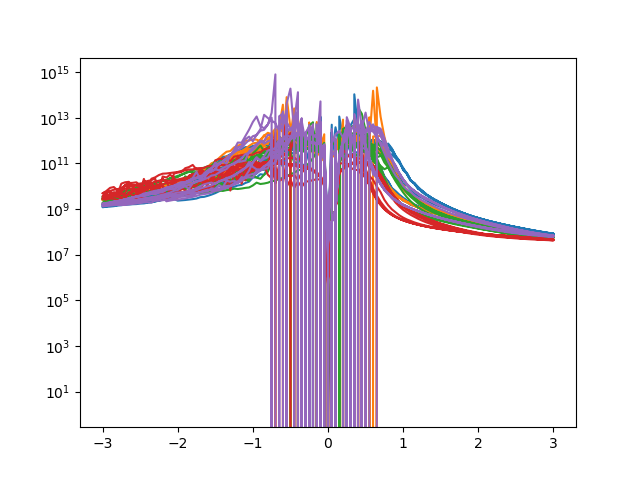

In [14]:
plt.figure()
for x in range (0,5):
    idx = x #63

    
  
    data = an.measurements[idx]['data']

    # List columns in dataframe
    print(list(data.columns))

    # Chose a column for x and y axis of the plot
    plt.plot(data['Source'], data['Resistance'])
    plt.yscale('log')

## Calc Mean Curve

In [12]:
selection = [0,1,2,3,4]
selection = [0,1,2,3,4]

start_from_cycle = 2
selected_cycles = {0: [], 1: [], 2: [], 3: [1,2,3,4], 4: []}
selected_cycles = {0: [], 1: [], 2: [], 3: [], 4: []}

mean_selection = []
for idx in selection:
    m = an.measurements[idx]
    data = m['data']
    # zero_v = data['Time'][data['Source'] == 0]
    # #display(zero_v)
    # idx_selected_zero_v = 3*(start_from_cycle-1)
    # t_selected_zero_v = zero_v.iloc[idx_selected_zero_v]
    selected_cycle_data = data[data['Repeat'] == start_from_cycle].reset_index(drop=True)
    max_num_cycles = data['Repeat'].iloc[-1]
    sel_cycles = selected_cycles[idx]
    if not sel_cycles:
        sel_cycles = [1,2,3,4,5]
    num_selected_cycles = len(sel_cycles) - start_from_cycle + 1
    #display(selected_cycle_data.head())
    for i in range(start_from_cycle+1, max_num_cycles+1):
        #print(i)
        if i not in sel_cycles:
            continue
        cycle_data = data[data['Repeat'] == i][['Voltage', 'Current', 'Resistance', 'Source']].reset_index(drop=True)
        add_df = selected_cycle_data[['Voltage', 'Current', 'Resistance', 'Source']].add(cycle_data, fill_value=0)
        
        selected_cycle_data[['Voltage', 'Current', 'Resistance', 'Source']] = add_df
        #display(cycle_data.head())
        #display(selected_cycle_data.head())
        
    selected_cycle_data[['Voltage', 'Current', 'Resistance', 'Source']] = selected_cycle_data[['Voltage', 'Current', 'Resistance', 'Source']] / num_selected_cycles
    new_idx = f'{idx}_mean'
    new_m = copy.deepcopy(m)
    new_m['data'] = selected_cycle_data
    an.measurements[new_idx] = new_m

    mean_selection.append(new_idx)

mean_selection

['0_mean', '1_mean', '2_mean', '3_mean', '4_mean']

## Split Measurement

In [13]:
selection = mean_selection

thr_pos = 0.1
thr_neg = -0.1

split_selection = []
split_selection_pos = []
split_selection_neg = []
split_selection_neg_1 = []
split_selection_neg_2 = []
for idx in selection:
    m = an.measurements[idx]
    data = m['data']
    new_data_pos = data[data['Source'] >= thr_pos]
    max_v_pos = data['Source'].max()
    #display(data['Time'][data['Source'] == max_v_pos])
    #display(data['Time'][data['Source'] == thr_pos]) 
    time_max_v_pos = data['Time'][data['Source'] == max_v_pos].tail(1).iloc[0]
    #time_max_v_pos = data['Time'].iloc[(data['Source']-max_v_pos).abs().argsort()[:1]]
    #print('time_max_v_pos', time_max_v_pos)
    
    #display(data['Time'][data['Source'] == thr_pos])
    #display(data['Time'].iloc[(data['Source']-thr_pos).abs().argsort()[:1]])
    #time_max_v_pos = data['Time'].iloc[(data['Source']-thr_pos).abs().argsort()[:1]]
    #time_min_v_pos = data['Time'][data['Source'] == thr_pos].iloc[-2]    

    new_data_pos_1 = new_data_pos[new_data_pos['Time'] <= time_max_v_pos]
    new_data_pos_2 = new_data_pos[new_data_pos['Time'] > time_max_v_pos]
    
    new_data_neg = data[data['Source'] <= thr_neg]
    max_v_neg = data['Source'].min()
    time_max_v_neg = data['Time'][data['Source'] == max_v_neg].tail(1).iloc[0]
    #time_max_v_neg = data['Time'].iloc[(data['Source']-max_v_neg).abs().argsort()[:1]]
    #time_min_v_neg = data['Time'][data['Source'] == thr_neg].iloc[-2]

    new_data_neg_1 = new_data_neg[new_data_neg['Time'] <= time_max_v_neg]
    new_data_neg_2 = new_data_neg[new_data_neg['Time'] > time_max_v_neg]
    
    new_idx_pos = f'{idx}_pos_1'
    new_m_pos = copy.deepcopy(m)
    new_m_pos['data'] = new_data_pos_1
    an.measurements[new_idx_pos] = new_m_pos

    new_idx_pos = f'{idx}_pos_2'
    new_m_pos = copy.deepcopy(m)
    new_m_pos['data'] = new_data_pos_2
    an.measurements[new_idx_pos] = new_m_pos

    new_idx_neg = f'{idx}_neg_1'
    new_m_neg = copy.deepcopy(m)
    new_m_neg['data'] = new_data_neg_1
    an.measurements[new_idx_neg] = new_m_neg

    new_idx_neg = f'{idx}_neg_2'
    new_m_neg = copy.deepcopy(m)
    new_m_neg['data'] = new_data_neg_2
    an.measurements[new_idx_neg] = new_m_neg
    

    split_selection += [f'{idx}_pos_1', f'{idx}_pos_2', f'{idx}_neg_1', f'{idx}_neg_2']
    split_selection_pos += [f'{idx}_pos_1', f'{idx}_pos_2']
    split_selection_neg += [f'{idx}_neg_1', f'{idx}_neg_2']
    split_selection_neg_1 += [f'{idx}_neg_1']
    split_selection_neg_2 += [f'{idx}_neg_2']

    
split_selection

['0_mean_pos_1',
 '0_mean_pos_2',
 '0_mean_neg_1',
 '0_mean_neg_2',
 '1_mean_pos_1',
 '1_mean_pos_2',
 '1_mean_neg_1',
 '1_mean_neg_2',
 '2_mean_pos_1',
 '2_mean_pos_2',
 '2_mean_neg_1',
 '2_mean_neg_2',
 '3_mean_pos_1',
 '3_mean_pos_2',
 '3_mean_neg_1',
 '3_mean_neg_2',
 '4_mean_pos_1',
 '4_mean_pos_2',
 '4_mean_neg_1',
 '4_mean_neg_2']

## Make Point Measurement

In [14]:
selection = split_selection_neg_2[0:4] # select branch
selection

['0_mean_neg_2', '1_mean_neg_2', '2_mean_neg_2', '3_mean_neg_2']

In [15]:
target_voltages = [-0.25, -0.5, -0.75, -1, -1.25, -1.5, -1.75, -2]

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    point_selection = []
    for v in target_voltages:
        data_v_list = []
        for idx in selection:
            m = an.measurements[idx]
            data = m['data']
            data_v = data.iloc[(data['Source']-v).abs().argsort()[:1]]
            #data_v = data[data['Source'] == v]
            T = int(m['T'])
            data_v['T'] = T
            data_v_list.append(data_v)
        #display(data_v_list)
        data_new = pd.concat(data_v_list)
        #display(data_new.head())
        m_new = copy.deepcopy(an.measurements[selection[0]])
        m_new['data'] = data_new
        m_new['V'] = v
        idx_new = f'{selection[0][-5::]}_v{v}'
        an.measurements[idx_new] = m_new

        point_selection += [idx_new]

point_selection

['neg_2_v-0.25',
 'neg_2_v-0.5',
 'neg_2_v-0.75',
 'neg_2_v-1',
 'neg_2_v-1.25',
 'neg_2_v-1.5',
 'neg_2_v-1.75',
 'neg_2_v-2']

In [16]:
an.print_measurements()

,timestamp,meas_name,cluster,device,T,V
0,2024-01-04 16:15:58,cleansweep5_c3x4_d9x1_T25_gap20,c3x4,d9x1,25,NaN
1,2024-01-04 16:32:24,cleansweep5_c3x4_d9x1_T5_gap20,c3x4,d9x1,5,NaN
2,2024-01-04 16:40:26,cleansweep5_c3x4_d9x1_T55_gap20,c3x4,d9x1,55,NaN
3,2024-01-04 16:50:48,cleansweep5_c3x4_d9x1_T105_gap20,c3x4,d9x1,105,NaN
4,2024-01-04 17:00:51,cleansweep5_c3x4_d9x1_T25_gap20,c3x4,d9x1,25,NaN
0_mean,2024-01-04 16:15:58,cleansweep5_c3x4_d9x1_T25_gap20,c3x4,d9x1,25,NaN
1_mean,2024-01-04 16:32:24,cleansweep5_c3x4_d9x1_T5_gap20,c3x4,d9x1,5,NaN
2_mean,2024-01-04 16:40:26,cleansweep5_c3x4_d9x1_T55_gap20,c3x4,d9x1,55,NaN
3_mean,2024-01-04 16:50:48,cleansweep5_c3x4_d9x1_T105_gap20,c3x4,d9x1,105,NaN
4_mean,2024-01-04 17:00:51,cleansweep5_c3x4_d9x1_T25_gap20,c3x4,d9x1,25,NaN


## Plot multiple measurements with legend 

In [25]:
#selection = [i for i in range(6,15)]
T_selection = 0

selection = [T_selection, f'{T_selection}_mean_pos_1', f'{T_selection}_mean_pos_2', f'{T_selection}_mean_neg_1', f'{T_selection}_mean_neg_2']
#selection = ['0_mean', '3_mean', '4_mean']

x_axis = 'Source'
y_axis = 'Current'

font = {'weight' : 'normal',
        'size'   : 14}
        
plt.rc('font', **font)

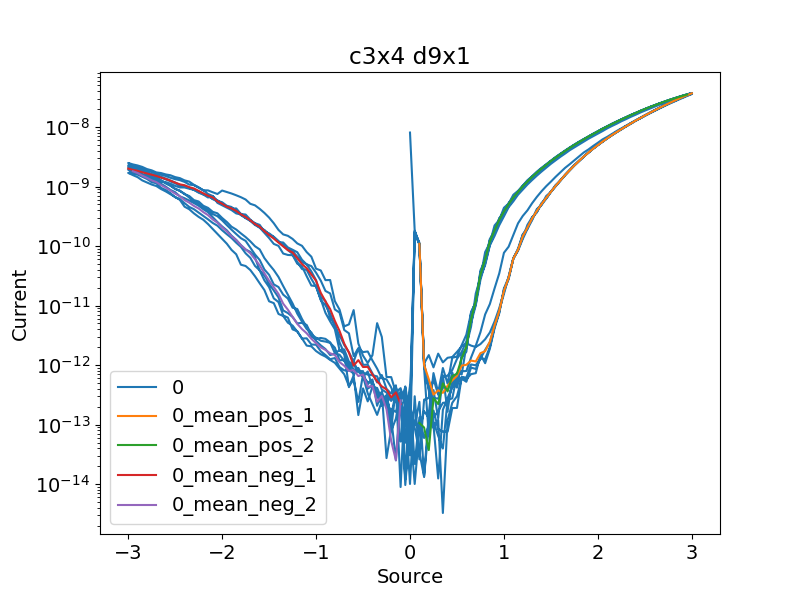

In [26]:
fig, ax = plt.subplots(figsize=(8,6))

scale = 'log'
outlier_thr = 1e30 #30
outlier_thr_low = 1e-20 #30


for idx in selection:
    m = an.measurements[idx]
    data = m['data']
    meas_name = m['meas_name']
    timestamp = m['timestamp']
    device = m['device']
    cluster = m['cluster']
    T = m['T']
    label_string = f'({timestamp}) {meas_name}'
    
    # Filter out outliers
    data = data[(np.abs(data['Current']) < outlier_thr) & (np.abs(data['Current']) > outlier_thr_low)]


    # Uncomment to try out different auto labelling schemes
    #label_string = f'({timestamp}) T={T}'
    label_string = idx
    
    if scale == 'log':
        ydata = np.abs(data[y_axis])

    ax.plot(data[x_axis], ydata, label=label_string)

m_title = an.measurements[selection[0]]
dev = m_title['device']
clu = m_title['cluster']
title_str = f'{clu} {dev}'
ax.set_title(title_str)
ax.set_xlabel(x_axis)
ax.set_ylabel(y_axis)
# set yscale to log if needed
ax.set_yscale(scale)
ax.legend()

In [27]:
safenames = [f'IV_mean_{title_str}']
figures = [fig]

In [28]:
save_figures(figures, safenames, directory, dpi=300, filetype='png')

/baltic/users/optolabdata/Experiments/EdwardHe/FinaleMessungen/Pt20/clean/IV_mean_c3x4_d9x1
Should file be overwritten: yes[y] / no [n] / no to all [nn] / yes to all [yy] / rename [r]:


 r


# Schottky Fit 

In [41]:
selection = split_selection_neg_2 # Select branch
sub_selection_fit = selection[0:4]

selection = sub_selection_fit

## Calc Schottky Fit 

e*phi 4.4311674309855034e-20
beta*0.4 1.426429316e-20
beta*0.75 2.6745549674999998e-20
beta*1.1 3.922680619e-20
beta*1.4499999999999997 5.1708062704999987e-20
beta*1.8 6.418931922e-20


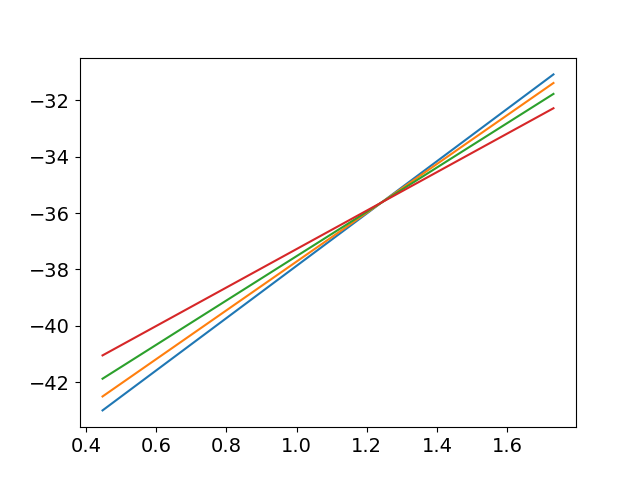

In [42]:
# Fitting parameters

# CrPt18 neg 1
phi = 2.54576211e-01 
beta = 3.85819575e-20
A_const = 1.54470633e-13

# # CrPt18 neg 2
# phi = 3.17067294e-01 
# beta = 3.98114756e-20
# A_const = 1.15107939e-13

# # Ptan21 neg 1
# phi = 3.52747691e-01
# beta = 4.79843260e-20
# A_const = 9.97848124e-14

# # Ptan21 neg 2
# phi = 3.12308750e-01
# beta = 4.40537914e-20
# A_const = 1.59668046e-14

# Pt neg 1
# phi = 2.08346884e-01
# beta = 3.28699158e-20
# A_const = 1.72533958e-16

# Pt neg 2
phi = 2.76571718e-01 
beta = 3.56607329e-20
A_const = 3.38638282e-16

# Constants
e = 1.60217663e-19 #C
k_B = 1.380649e-23 #m2 kg s-2 K-1

# Barrier 
#phi = m*k_B/e

print('e*phi', e*phi)
for V_test in np.linspace(0.4, 1.8, num = 5):
    print(f'beta*{V_test}', beta*V_test)

V_fit = np.linspace(0.2, 3, num=100)
T_fit = np.linspace(5, 105, num=100)

def schottky_fit(sqrt_V, T, phi, beta, A_const):
    return -(e*phi - beta*sqrt_V) / k_B *1/(T+273.15) + np.log(A_const)

plt.figure()
for T in [5, 25, 55, 105]:
    
    sqrt_V = np.sqrt(V_fit)
    plt.plot(sqrt_V, schottky_fit(sqrt_V, T, phi, beta, A_const))
    




## Automatic Schottky Fit 

In [43]:
from scipy.optimize import curve_fit

In [44]:
def x_axis_fnct(x):
    return np.sqrt(np.abs(x))

def y_axis_fnct(y,T):
    return np.log(np.abs(y)/(T+273.15)**2)

In [45]:
V_lims_sqrt = [1, 1.4]
V_lims_calc = np.array(V_lims_sqrt)**2
print(V_lims_calc)

[1.   1.96]


In [46]:
V_lims = [1, 2]

In [47]:

sqrt_V_array = []
T_arr = []
y_data_arr = []
for idx in sub_selection_fit:
    m = an.measurements[idx]
    data = m['data']
    meas_name = m['meas_name']
    timestamp = m['timestamp']
    device = m['device']
    cluster = m['cluster']
    selected_data = data[(data['Source'].abs() >= V_lims[0]) & (data['Source'].abs() <= V_lims[1])]
    #display(selected_data.head())
    num_V_points = len(selected_data)
    #print(num_V_points)
    T = int(m['T'])
    T_arr.append(np.array([T]*num_V_points))
    
    sqrt_V = np.array(x_axis_fnct(selected_data['Source']))
    sqrt_V_array.append(sqrt_V)
    
    y_data = np.array(y_axis_fnct(selected_data['Current'], T))
    y_data_arr.append(y_data)

M = np.vstack((np.array(sqrt_V_array).ravel(), np.array(T_arr).ravel()))
Y = np.array(y_data_arr).ravel()

p0 = [phi, beta, A_const]

def _thermionic(M, phi, beta, A_const):
    sqrt_V, T = M
    return schottky_fit(sqrt_V, T, phi, beta, A_const)


popt, pcov = curve_fit(_thermionic, M, Y, p0, nan_policy='omit')
print('phi, beta, A_const')
print(popt)
#T_arr

phi, beta, A_const
[2.76571725e-01 3.56607335e-20 3.38638303e-16]


## Schottky Plot

In [48]:
def x_axis_fnct(x):
    return np.sqrt(np.abs(x))

def y_axis_fnct(y,T):
    return np.log(np.abs(y)/(T+273.15)**2)

# def y_axis_fnct(y,T):
#     return np.log(np.abs(y))

x_axis_label = r'$\sqrt{|V|}$'

y_axis_label = r'$\log\left(|I|/T^2\right)$'

In [49]:
x_axis = 'Source'
y_axis = 'Current'

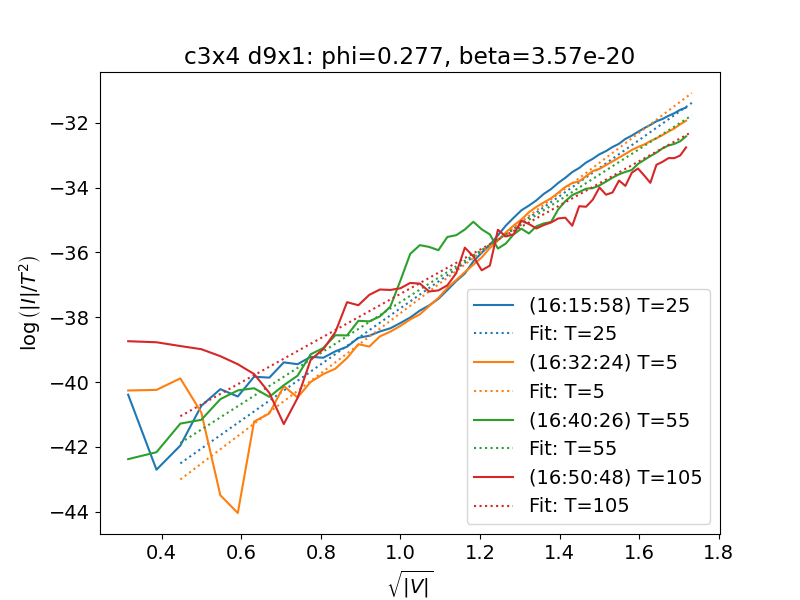

In [50]:
fig, ax = plt.subplots(figsize=(8,6))

scale = 'linear'
outlier_thr = 1e30 #30
outlier_thr_low = 1e-20 #30

# USed to calculate slope (upper/lower limit for sqrt voltage)
thr_V_sqrt_high = 1
thr_V_sqrt_low = 0.6

plot_fit = True
colors = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8']

for i, idx in enumerate(selection):
    m = an.measurements[idx]
    data = m['data'].copy()
    meas_name = m['meas_name']
    timestamp = m['timestamp']
    device = m['device']
    cluster = m['cluster']
    T = m['T']
        
    # Filter out outliers
    # data = data[(np.abs(data['Current']) < outlier_thr) & (np.abs(data['Current']) > outlier_thr_low)]


    # Uncomment to try out different auto labelling schemes
    label_string = f'({timestamp:%H:%M:%S}) T={T}'
    
    if scale == 'log':
        ydata = np.abs(data[y_axis])
    else:
        ydata = data[y_axis]

    xdata = x_axis_fnct(data[x_axis])
    ydata = y_axis_fnct(ydata, int(T))
    
    color = colors[i]
    
    ax.plot(xdata, ydata, label=label_string, color=color)
    
    #Fit
    sqrt_V = np.sqrt(V_fit)
    fit_label = f'Fit: T={T}'
    if plot_fit and idx in sub_selection_fit:
        ax.plot(sqrt_V, schottky_fit(sqrt_V, int(T), phi, beta, A_const), label=fit_label, linestyle = ':', color=color)

m_title = an.measurements[selection[0]]
dev = m_title['device']
clu = m_title['cluster']
title_str = f'{clu} {dev}: phi={phi:.3g}, beta={beta:.3g}'
ax.set_title(title_str)
ax.set_xlabel(x_axis_label)
ax.set_ylabel(y_axis_label)
# set yscale to log if needed
ax.set_yscale(scale)
ax.legend()



In [51]:
sel_str = '_'.join(selection)
safenames = [f'Schottky_{title_str}_{sel_str}']
figures = [fig]

In [52]:
save_figures(figures, safenames, directory, dpi=300, filetype='png')

/baltic/users/optolabdata/Experiments/EdwardHe/FinaleMessungen/Pt20/clean/Schottky_c3x4_d9x1_phi=0_277__beta=3_57e-20_0_mean_neg_2_1_mean_neg_2_2_mean_neg_2_3_mean_neg_2


## Plot Temperature Schottky Plot

In [53]:
def x_axis_fnct(x):
    return 1000/(x+273.15)

def y_axis_fnct(y,T):
    return np.log(np.abs(y)/(T+273.15)**2)

# def y_axis_fnct(y,T):
#     return y

x_axis_label = r'$1000/T$'

y_axis_label = r'$\log\left(|I|/T^2\right)$'

In [58]:
#selection = [i for i in range(6,15)]
selection = [0,1,2]
selection = point_selection[0:5]
selection = point_selection[3:8]

x_axis = 'T'
y_axis = 'Current'

In [59]:
selection

['neg_2_v-1', 'neg_2_v-1.25', 'neg_2_v-1.5', 'neg_2_v-1.75', 'neg_2_v-2']

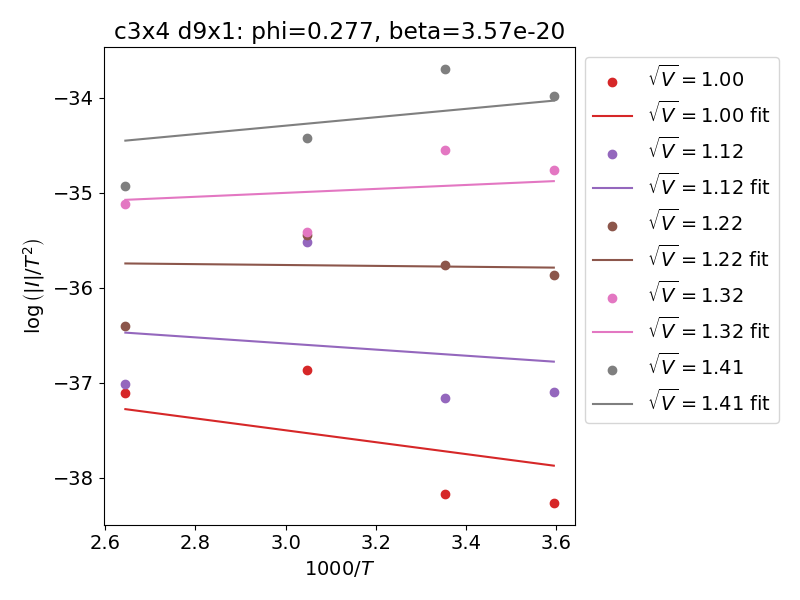

In [61]:
fig, ax = plt.subplots(figsize=(8,6))

scale = 'linear'
outlier_thr = 1e30 #30
outlier_thr_low = 1e-20 #30

# USed to calculate slope (upper/lower limit for 1000/Temperature [K])
thr_T_high = 4
thr_T_low = 2.6


plot_fit = True

phi_list = []
phi_list_fit = []
colors = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9']
colors = ['C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9']
for i, idx in enumerate(selection):
    m = an.measurements[idx]
    data = m['data'].copy()
    meas_name = m['meas_name']
    timestamp = m['timestamp']
    device = m['device']
    cluster = m['cluster']
    sqrt_V = np.sqrt(np.abs(m['V']))
            
    # Filter out outliers
    # data = data[(np.abs(data['Current']) < outlier_thr) & (np.abs(data['Current']) > outlier_thr_low)]

    #display(data.head())
    # Uncomment to try out different auto labelling schemes
    label_string = r'$\sqrt{V} = $' + f'{sqrt_V:.2f}'
    
    if scale == 'log':
        ydata = np.abs(data[y_axis])
    else:
        ydata = data[y_axis]

        
    #display(an.measurements[idx]['data'])
        
    # xdata = x_axis_fnct(data[x_axis]).reset_index(drop=True)
    # ydata = y_axis_fnct(ydata, int(T)).reset_index(drop=True)
    
    T = np.array(data[x_axis])
    
    xdata = x_axis_fnct(data[x_axis])
    ydata = y_axis_fnct(ydata, T)
    
    color = colors[i]
    ax.scatter(xdata, ydata, label=label_string, color=color)

    #Fit
    x_axis_t = 1000/(T_fit+273.15)
    if plot_fit:
        ax.plot(x_axis_t, schottky_fit(sqrt_V, T_fit, phi, beta, A_const), label=label_string + ' fit', color=color)

m_title = an.measurements[selection[0]]
dev = m_title['device']
clu = m_title['cluster']
title_str = f'{clu} {dev}: phi={phi:.3g}, beta={beta:.3g}'
ax.set_title(title_str)
ax.set_xlabel(x_axis_label)
ax.set_ylabel(y_axis_label)
# set yscale to log if needed
ax.set_yscale(scale)
ax.legend(bbox_to_anchor=[1, 1])
fig.tight_layout()


In [62]:
sel_str = '_'.join(selection)
safenames = [f'Schottky_T_{title_str}_{sel_str}']
figures = [fig]

In [63]:
save_figures(figures, safenames, directory, dpi=300, filetype='png')

/baltic/users/optolabdata/Experiments/EdwardHe/FinaleMessungen/Pt20/clean/Schottky_T_c3x4_d9x1_phi=0_277__beta=3_57e-20_neg_2_v-1_neg_2_v-1_25_neg_2_v-1_5_neg_2_v-1_75_neg_2_v-2
